In [106]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pickle, shutil, random

In [107]:
BASE_PATH = Path('/project/volume/data/out/NIMH-CHEFS')
LABELS = ['Afraid', 'Angry', 'Happy', 'Neutral', 'Sad']

IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))
IMAGE_PATHS_STR = [str(path) for path in IMAGE_PATHS]

In [108]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n")
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n")

#### Show samples

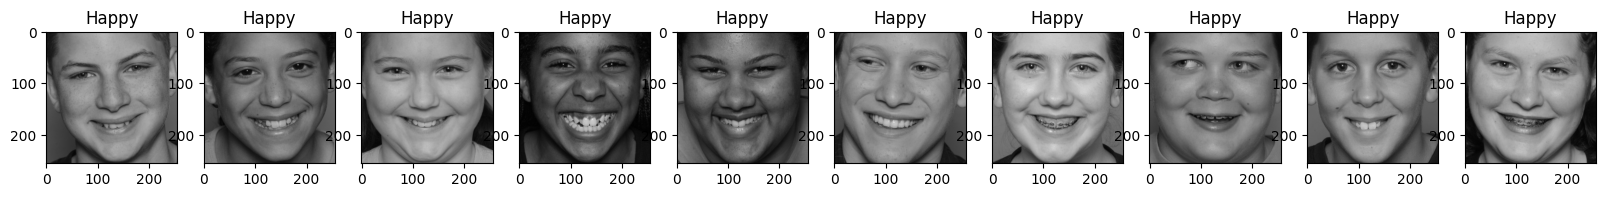

In [109]:
fig = plt.figure(figsize=(20,20))

for i in range(10):

    fig.add_subplot(1, 10, i + 1)
    plt.imshow(np.array(cv2.imread(str(IMAGE_PATHS[i]))), cmap='gray')
    label = Path(IMAGE_PATHS[i]).parent.name
    plt.title(label)

plt.show()

{'Happy': 108, 'Sad': 104, 'Neutral': 111, 'Angry': 104, 'Afraid': 106}


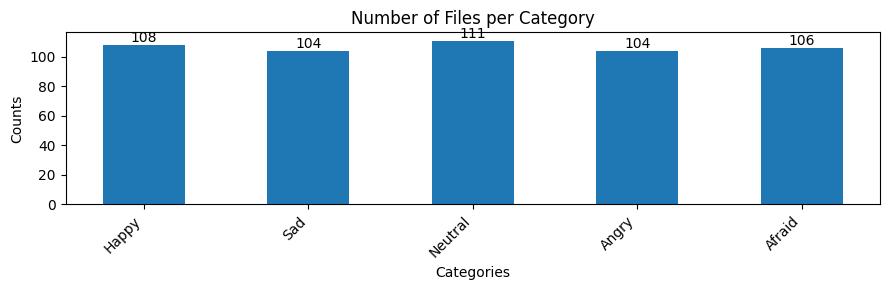

In [110]:
from collections import Counter
from pathlib import Path

def get_distribution():
    nbr_per_cat = Counter(Path(file).parent.name for file in IMAGE_PATHS)
    print(dict(nbr_per_cat))

    categories = list(nbr_per_cat.keys())
    counts = list(nbr_per_cat.values())

    plt.figure(figsize=(9, 3))
    bars = plt.bar(categories, counts, width=0.5)

    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Number of Files per Category')
    plt.xticks(rotation=45, ha='right')

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

get_distribution()

In [111]:
def to_grayscale(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_image(img, size):
    return cv2.resize(img, (size,size))

In [112]:
train_prop = 0.6
test_prop = 0.2
valid_prop = 0.2

number_of_images = len(list(BASE_PATH.rglob('*.jpg')))


n_train = int((number_of_images * train_prop) + 0.5)
n_valid = int((number_of_images * valid_prop) + 0.5)
n_test = number_of_images - n_train - n_valid


print(f"[INFO] Number of images used in training ... {str(n_train)} ({str(train_prop * 100)}%)")
print(f"[INFO] Number of images used in validation ...{str(n_valid)} ({str(valid_prop * 100)}%)")
print(f"[INFO] Number of images used in testing ... {str(n_test)} ({str(test_prop * 100)}%)")

[INFO] Number of images used in training ... 320 (60.0%)
[INFO] Number of images used in validation ...107 (20.0%)
[INFO] Number of images used in testing ... 106 (20.0%)


In [113]:
def split_and_move():
    for label in tqdm(LABELS):
        folder_path = BASE_PATH / label
        train_destination = BASE_PATH / "train" / label
        val_destination = BASE_PATH / "val" / label
        test_destination = BASE_PATH / "test" / label

        train_destination.mkdir(parents=True, exist_ok=True)
        val_destination.mkdir(parents=True, exist_ok=True)
        test_destination.mkdir(parents=True, exist_ok=True)

        files = list(folder_path.rglob('*.jpg'))
        random.shuffle(files)
        train_n = (int((len(files) * train_prop) + 0.5))
        val_n = (int((len(files) * valid_prop) + 0.2))
        
        for file_idx, file in enumerate(list(folder_path.rglob('*.jpg'))):
            if file_idx < train_n:
                shutil.move(str(file), train_destination)
            elif file_idx < train_n + val_n:
                shutil.move(str(file), val_destination)
            else:
                shutil.move(str(file), test_destination)

        if folder_path.exists() and folder_path.is_dir():
            shutil.rmtree(folder_path)

In [114]:
split_and_move()

print('[INFO] Number of images in training set ...', len(list((BASE_PATH / 'train').rglob('*.jpg'))))
print('[INFO] Number of images in test set ...', len(list((BASE_PATH / 'test').rglob('*.jpg'))))
print('[INFO] Number of images in validation set ...', len(list((BASE_PATH / 'val').rglob('*.jpg'))))

100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 668.10it/s]

[INFO] Number of images in training set ... 320
[INFO] Number of images in test set ... 107
[INFO] Number of images in validation set ... 106


## HOG

In [115]:
def extract_hog_features():
    hog_data = []
    hog_labels = []

    for p in tqdm(IMAGE_PATHS):
        im = to_grayscale(str(p))
        im = resize_image(im, 128)
        
        # extract hog feature descriptor
        fd1 = hog(im, orientations=7, pixels_per_cell=(8, 8),
                  cells_per_block=(4, 4), 
                  block_norm='L2-Hys',
                  transform_sqrt=False,
                  feature_vector=True)

        label = Path(p).parent.name
        hog_labels.append(label)
        hog_data.append(fd1)

    hog_data = np.array(hog_data)
    hog_labels = np.array(hog_labels)
    print("[INFO] Number of features ...", str(hog_data.shape[1]))
    print("[INFO] Number of labels ...", str(hog_labels.shape[0]))
    return hog_data, hog_labels

def compute_hog_feature_size(image_shape, orientations, pixels_per_cell, cells_per_block):
    height, width = image_shape, image_shape
    num_cells_x = width // pixels_per_cell
    num_cells_y = height // pixels_per_cell
    num_blocks_x = num_cells_x - cells_per_block + 1
    num_blocks_y = num_cells_y - cells_per_block + 1
    features_per_block = cells_per_block * cells_per_block * orientations
    total_features = num_blocks_x * num_blocks_y * features_per_block
    print("[INFO] Size of HOG feature vector ...", total_features)

# Parameters
orientations = 7
pixels_per_cell = 8
cells_per_block = 4
image_shape = 64

compute_hog_feature_size(image_shape, orientations, pixels_per_cell, cells_per_block)

[INFO] Size of HOG feature vector ... 2800


In [116]:
hog_data, hog_labels = extract_hog_features()

x_train, x_test, y_train, y_test = train_test_split(hog_data, hog_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_hog = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)

pickle.dump(best_estimator_hog, open('/project/volume/models/hog_model.p', 'wb'))

print_score(best_estimator_hog, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_hog, x_train, y_train, x_test, y_test, train=False)

100%|████████████████████████████████████████████████████████████████████| 533/533 [00:03<00:00, 135.38it/s]


[INFO] Number of features ... 18928
[INFO] Number of labels ... 533
[INFO] Number of images used in training ... 426
[INFO] Number of images used in testing ... 107
[INFO] Best params ... {'C': 100, 'gamma': 0.001}
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Afraid       1.00      1.00      1.00        85
       Angry       1.00      1.00      1.00        83
       Happy       1.00      1.00      1.00        86
     Neutral       1.00      1.00      1.00        89
         Sad       1.00      1.00      1.00        83

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426

_______________________________________________
Confusion Matrix: 
 [[85  0  0  0  0]
 [ 0 83  0  0  0]
 [ 0  0 86  0  0]
 [ 0  0  0 89  0]
 [ 0  0  0  0 83]]

Test Result:
Accuracy Score

## Landmarks

In [117]:
from mediapipe import Image
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import mediapipe as mp

In [118]:
model_path_mesh = '/project/volume/models/face_landmarker.task'

base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

W0000 00:00:1717438433.605680     142 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [119]:
def read_mp_cv2_image(image_path):
    return Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

def colortogray(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return imgray

def resizeImage(image, size):
    return cv2.resize(image, (size,size))

In [120]:
def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [121]:
def extract_landmarks():
    lm_labels = []
    lm_data = []

    for file in tqdm(IMAGE_PATHS):
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
        detection_result = detector_mesh.detect(rgb_frame)

        if detection_result.face_landmarks:
            lm_array = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
            lm_labels.append(file.parent.name)
            lm_data.append(lm_array)

    lm_labels = np.array(lm_labels)
    lm_data = np.array(lm_data)

    return lm_data, lm_labels

In [122]:
lm_data, lm_labels = extract_landmarks()

x_train, x_test, y_train, y_test = train_test_split(lm_data, lm_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_landmark = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_landmark, open('/project/volume/models/lm_model.p', 'wb'))

print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=False)

100%|█████████████████████████████████████████████████████████████████████| 533/533 [00:09<00:00, 55.64it/s]

[INFO] Number of images used in training ... 426
[INFO] Number of images used in testing ... 107


[INFO] Best params ... {'C': 1000, 'gamma': 0.1}
Train Result:
Accuracy Score: 93.19%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Afraid       1.00      0.94      0.97        85
       Angry       0.84      0.95      0.89        83
       Happy       1.00      1.00      1.00        86
     Neutral       0.89      0.91      0.90        89
         Sad       0.95      0.86      0.90        83

    accuracy                           0.93       426
   macro avg       0.94      0.93      0.93       426
weighted avg       0.94      0.93      0.93       426

_______________________________________________
Confusion Matrix: 
 [[80  1  0  4  0]
 [ 0 79  0  3  1]
 [ 0  0 86  0  0]
 [ 0  5  0 81  3]
 [ 0  9  0  3 71]]

Test Result:
Accuracy Score: 76.64%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Afraid       0.86      0.8

## Pure images

In [123]:
def pure_pixels():
    pixel_labels = []
    pixel_data = []

    for file in tqdm(IMAGE_PATHS):     
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        
        pixel_labels.append(file.parent.name)
        pixel_data.append(np.array(img_cv2).flatten())

    pixel_labels = np.array(pixel_labels)
    pixel_data = np.array(pixel_data)

    return pixel_data, pixel_labels

In [124]:
pixel_data, pixel_labels = pure_pixels()

x_train, x_test, y_train, y_test = train_test_split(pixel_data, pixel_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_pixel = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_pixel, open('/project/volume/models/pixel_model.p', 'wb'))

print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=False)

100%|████████████████████████████████████████████████████████████████████| 533/533 [00:00<00:00, 575.30it/s]


[INFO] Number of images used in training ... 426
[INFO] Number of images used in testing ... 107
[INFO] Best params ... {'C': 1, 'gamma': 0.1}
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Afraid       1.00      1.00      1.00        85
       Angry       1.00      1.00      1.00        83
       Happy       1.00      1.00      1.00        86
     Neutral       1.00      1.00      1.00        89
         Sad       1.00      1.00      1.00        83

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426

_______________________________________________
Confusion Matrix: 
 [[85  0  0  0  0]
 [ 0 83  0  0  0]
 [ 0  0 86  0  0]
 [ 0  0  0 89  0]
 [ 0  0  0  0 83]]

Test Result:
Accuracy Score: 20.56%
_______________________________________________
CLASSIFICATION 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### K-fold cross validation

In [125]:
n_splits_values = [3, 5, 10]

In [127]:
classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

modes = {'hog': best_estimator_hog, 
         'pixel': best_estimator_pixel,
         'landmark': best_estimator_landmark
        }

for mode, model in modes.items():
    print(mode)
    for n_splits in n_splits_values:
        cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
        scores = cross_val_score(model, lm_data, lm_labels, scoring='accuracy', cv=cv, n_jobs=-1)
        print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")

hog
3-Fold CV: 0.38 accuracy with a standard deviation of 0.01
5-Fold CV: 0.41 accuracy with a standard deviation of 0.06
10-Fold CV: 0.46 accuracy with a standard deviation of 0.09
pixel
3-Fold CV: 0.28 accuracy with a standard deviation of 0.03
5-Fold CV: 0.29 accuracy with a standard deviation of 0.05
10-Fold CV: 0.32 accuracy with a standard deviation of 0.07
landmark
3-Fold CV: 0.71 accuracy with a standard deviation of 0.01
5-Fold CV: 0.72 accuracy with a standard deviation of 0.05
10-Fold CV: 0.73 accuracy with a standard deviation of 0.05
